# Model

In [84]:
from custom_transformers import ModifiedBertForSequenceClassification
from transformers import AutoTokenizer
import torch

In [ ]:
model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained('/home/Models/TookaBERT-Base/', )

In [3]:
tokens = tokenizer(
    text=['سلام', 'خوبی؟', 'حالت چطوره؟'],
    return_tensors='pt',
    padding=True,
    truncation=True
).to(model.device)

In [4]:
labels = torch.randint(0, 2, (3,163), dtype=torch.float32)

In [15]:
outputs = model(**tokens, labels=labels.to(model.device))

In [18]:
outputs.keys()

odict_keys(['loss', 'logits'])

In [19]:
model.config.problem_type

'multi_label_classification'

# DataLoader

In [1]:
from custom_transformers import ModifiedBertForSequenceClassification
from custom_transformers.utils.data import SQLDataset
from custom_transformers.utils.loss import BCEFocalLossWithLogits
from torch.utils.data import DataLoader
from transformers import get_scheduler
import torch
import os
from ast import literal_eval
from dotenv import load_dotenv
from collections import Counter
import matplotlib.pyplot as plt
from custom_transformers.utils.trainer import Trainer
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    device_map='auto',
)

# for name, param in model.named_parameters():
#     if name not in ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']:
#         param.requires_grad = False

connection_params = {
    'dbname': os.getenv('DBNAME'),
    'user': os.getenv('USERNAME'),
    'password': os.getenv('PASS'),
    'host': os.getenv('HOST', 'localhost'),
    'port': os.getenv('PORT', '5432')
}
dataset = SQLDataset(
    pretrained_model_name_or_path='/home/Models/TookaBERT-Base/',
    connection_params=connection_params,
    num_classes=163
)

Some weights of ModifiedBertForSequenceClassification were not initialized from the model checkpoint at /home/Models/TookaBERT-Base/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
cursor = dataset.connection.cursor()

query = """
    SELECT labels2
    FROM dbo.activity 
    WHERE labels2 IS NOT NULL AND labels2 NOT LIKE '%[]%'
"""

cursor.execute(query)
labels = [literal_eval(row[0]) for i, row in enumerate(cursor.fetchall())]

# Flatten the list to count occurrences of each label
flat_labels = [label for sublist in labels for label in sublist]

# Count occurrences of each label
label_counts = Counter(flat_labels)

total_samples = sum(label_counts.values())

# Inverse of frequency for each class
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Normalize weights (optional but can help to stabilize training)
max_weight = max(class_weights.values())
class_weights = {label: weight / max_weight for label, weight in class_weights.items()}

num_classes = 163
class_weights_tensor = torch.zeros(num_classes, dtype=torch.float32)

for label, weight in class_weights.items():
    class_weights_tensor[label] = weight
class_weights_tensor = class_weights_tensor.to(model.device)

# Apply log transformation and scaling
log_scaled_weights = torch.log(class_weights_tensor + 1e-10)  # Avoid log(0)
log_scaled_weights = (log_scaled_weights - log_scaled_weights.min()) / (log_scaled_weights.max() - log_scaled_weights.min())

# Scale class weights from [0, 1] to [0.2, 1]
scaled_class_weights = 0.8 * log_scaled_weights + 0.2

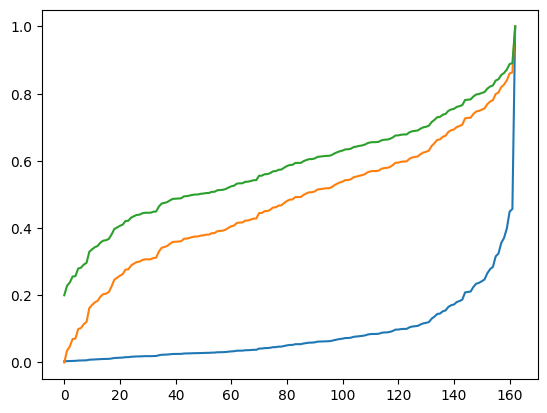

In [4]:
plt.plot(sorted(class_weights_tensor.cpu()))
plt.plot(sorted(log_scaled_weights.cpu()))
plt.plot(sorted(scaled_class_weights.cpu()))
plt.show()

In [5]:
train_indices, test_indices = train_test_split(
    list(dataset.id_map.keys()),
    test_size=0.1,
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, 32, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)
test_loader = DataLoader(test_dataset, 32, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)


# optimizer = AdamW(model.parameters(), lr=5e-5)
#--------------------------------------------------------------------------------------------------------------#
# Define the parameters for the frozen and unfrozen layers
frozen_params = []
unfrozen_params = []

for name, param in model.named_parameters():
    if name in ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']:
        # These layers will have their own learning rate
        unfrozen_params.append(param)
    else:
        # Freezing other layers (don't update their gradients)
        frozen_params.append(param)
optimizer = torch.optim.AdamW(
    [
        {'params': frozen_params, 'lr': 1e-6},   # Frozen layers have a smaller learning rate
        {'params': unfrozen_params, 'lr': 5e-5},  # Unfrozen layers have a larger learning rate
    ],
)
#--------------------------------------------------------------------------------------------------------------#

loss_fn = BCEFocalLossWithLogits(gamma=2, alpha=0.957, class_weights=scaled_class_weights, reduction="mean")

num_epochs = 20
num_training_steps = len(train_loader) * num_epochs 
warmup_steps = int(0.1 * num_training_steps)

scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

trainer = Trainer(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    test_loader
)

In [ ]:
trainer.fit(num_epochs)

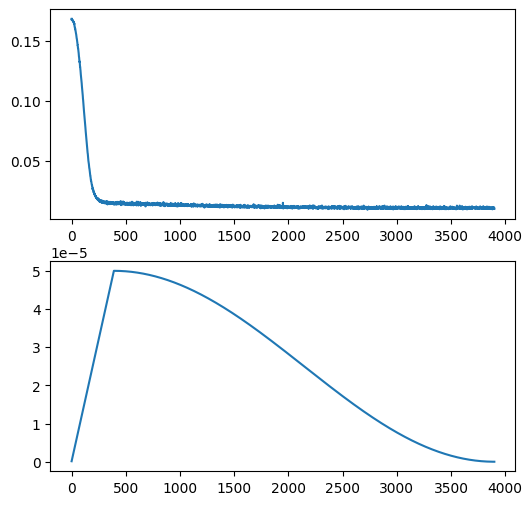

In [27]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot([loss for losses in trainer.losses for loss in losses])
plt.subplot(2, 1, 2)
plt.plot(trainer.learning_rates)

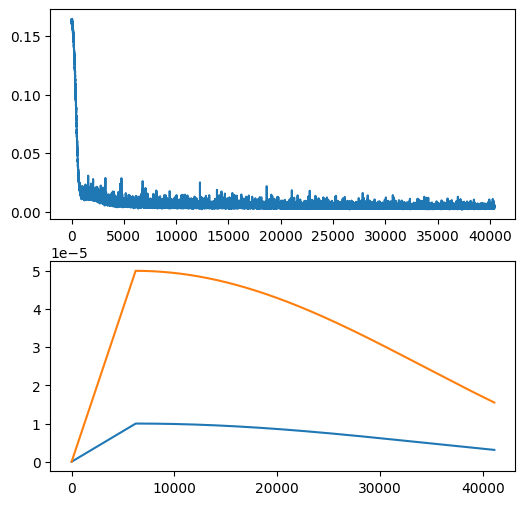

In [13]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot([loss for losses in trainer.losses for loss in losses])
plt.subplot(2, 1, 2)
plt.plot([lr[0] * 10 for lr in trainer.learning_rates])
plt.plot([lr[1] for lr in trainer.learning_rates])

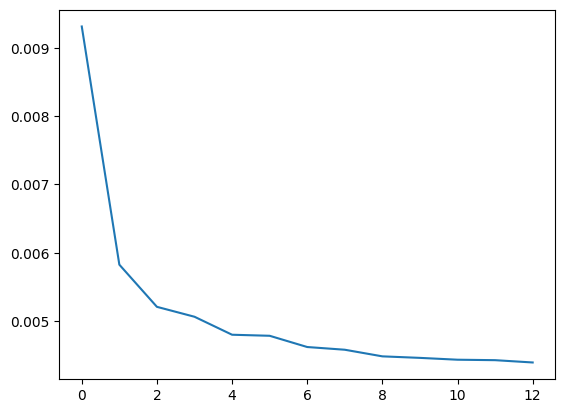

In [14]:
plt.plot(trainer.validation_loss)

In [15]:
tokens = dataset.tokenizer(
    'ارایه کلیه خدمات مهندسی کشاورزی شامل مشاوره اجرا نظارت بر اجرای انواع طرحهای ابیاری قطره ای بارانی تحت فشار و برقی کردن چاه های کشاورزی جهت بهبود عملیات زراعی در مزارع کشاورزی و باغات و تسطیح و اماده سازی و ابخیزداری و زهکشی کلیه زمینهای کشاورزی باغداری ایجاد فضای سبز گلخانه های فضای ازاد تهیه تولید تکثیر و پرورش گلهای اپارتمانی و انواع نهال تهیه تولید خرید فروش بسته بندی واردات صادرات انواع کودهای شیمیایی انواع بذر و نشا و کمپوست و سموم نباتی و ماشین الات کشاورزی و دامپروری ارایه خدمات مشاوره در زمینه بهبود عملیات زراعی و باغداری شناسایی و ردیابی افات زراعی و از بین بردن این افات بصورت علمی شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه امور بازرگانی شامل واردات صادرات ترخیص حق العمل کاری کلیه کالاهای مجاز از کلیه گمرکات و بنادر کشور و شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه عملیات اجرایی انواع طرحهای مخابراتی تاسیساتی ساختمانی راهسازی و گاز رسانی ابرسانی شهری و روستایی صنعتی شامل حفاری کابل کشی لوله گذاری کانال سازی خاکبرداری و جدول کشی انجام کلیه امور پروژه های ساختمانی مسکونی اسفالت کاری اسکلت سازی و محوطه سازی و تخریب و خاکبرداری خاکریزی و پی کنی دیوار چینی کلیه امور نقشه کشی (Gps – GPRS) کلیه امور اسنادی (خدمات اسنادی قبض انبار منطقه ویژه اصلاحیه مانیفست صورتحساب مجوز خروج کالا (بیجک) تسویه و صورت مجالس شناور صورت وضعیت خروج شناور)',
    truncation=True,
    padding=True,
    return_tensors='pt'
)

In [16]:
with torch.no_grad():
    output = trainer.model(**tokens.to('cuda'))

In [17]:
batch = train_loader.__iter__().__next__()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
with torch.no_grad():
    outputs = trainer.model(**batch.to('cuda'))

In [44]:
torch.argwhere(batch['labels'][1]).view(-1)

tensor([ 26,  29,  33,  37,  40, 102, 104, 110, 159, 162], device='cuda:0')

In [45]:
torch.argwhere(torch.sigmoid(outputs.logits[1]) > 0.25).view(-1)

tensor([ 26,  37, 100, 102, 104, 110, 142, 159, 161, 162], device='cuda:0')

In [47]:
torch.argwhere(torch.sigmoid(output['logits'][0]) > 0.25).cpu().view(-1)

tensor([  9,  26,  31,  40,  85, 142])

In [37]:
dataset.tokenizer.save_pretrained('./saved_models/myBERT-Base3/')
trainer.model.save_pretrained('./saved_models/myBERT-Base3/', safe_serialization=True)
trainer.model.save_pretrained('./saved_models/myBERT-Base3/', safe_serialization=False)